In [1]:
import numpy as np

import sys 
sys.path.append(r'../Python Script/')

from sympy import symbols, simplify, derive_by_array
from scipy.integrate import solve_ivp
from xLSINDy import *
from sympy.physics.mechanics import *
from sympy import *
import sympy
import sympy
import torch
import HLsearch as HL
import matplotlib.pyplot as plt

In [2]:
import time

def generate_data(func, time, init_values):
    sol = solve_ivp(func,[time[0],time[-1]],init_values,t_eval=time, method='RK45',rtol=1e-10,atol=1e-10)
    return sol.y.T, np.array([func(0,sol.y.T[i,:]) for i in range(sol.y.T.shape[0])],dtype=np.float64)

def pendulum(t,x):
    return x[1],-9.81*np.sin(x[0])

g=9.81
mp=0.5

mc=1
l=1

def cartpole(t,y,f=0.0):
    theta,x,thetadot,xdot = y
    xdotdot = (f+mp*np.sin(theta)*(l*thetadot**2+g*np.cos(theta)))/(mc+mp*np.sin(theta)**2)
    thetadotdot = (-f*np.cos(theta)-mp*l*thetadot**2*np.cos(theta)*np.sin(theta)-(mc+mp)*g*np.sin(theta))/(l*(mc+mp*np.sin(theta)**2))
    return thetadot,xdot,thetadotdot,xdotdot

In [3]:
#Saving Directory
rootdir = "../Cart Pendulum/"

num_sample = 100
create_data = False
training = False

a = 2
b = 2
noiselevel = a*10**(-b)

In [4]:
if(create_data):
    X, Xdot = [], []
    for i in range(num_sample):
        t = np.arange(0,5,0.01)
        theta = np.random.uniform(-np.pi, np.pi)
        thetadot = np.random.uniform(0,0)

        y0=np.array([theta, thetadot,0, 0])
        x,xdot = generate_data(cartpole,t,y0)
        X.append(x)
        Xdot.append(xdot)
    X = np.vstack(X)
    Xdot = np.vstack(Xdot) 
    np.save(rootdir + "Data/X.npy", X)
    np.save(rootdir + "Data/Xdot.npy",Xdot)

  
else:
    X = np.load(rootdir + "Data/X.npy")
    Xdot = np.load(rootdir + "Data/Xdot.npy")

In [5]:
states_dim = 4
states = ()
states_dot = ()
for i in range(states_dim):
    if(i<states_dim//2):
        states = states + (symbols('x{}'.format(i)),)
        states_dot = states_dot + (symbols('x{}_t'.format(i)),)
    else:
        states = states + (symbols('x{}_t'.format(i-states_dim//2)),)
        states_dot = states_dot + (symbols('x{}_tt'.format(i-states_dim//2)),)
print('states are:',states)
print('states derivatives are: ', states_dot)

states are: (x0, x1, x0_t, x1_t)
states derivatives are:  (x0_t, x1_t, x0_tt, x1_tt)


In [6]:
#Turn from sympy to str
states_sym = states
states_dot_sym = states_dot
states = list(str(descr) for descr in states)
states_dot = list(str(descr) for descr in states_dot)

In [9]:
#identifier = "no"
identifier = str(a) + "e-0" + str(b)

if(training==False):
    with open(rootdir + "Data/lagrangian_" + identifier + "_noise.txt") as f:
        L = f.readline()
        print(L)
        expr = L.split(" +")
        device = "cuda:0"
        xi_L = torch.ones(len(expr),device=device)
        mask = torch.ones(len(expr),device=device)
        

1.994*x0_t*x1_t*cos(x0) + 2.993*x1_t**2 + 19.534*cos(x0) + x0_t**2


In [10]:
#obtaining equations of motions
x0 = dynamicsymbols(states[0])
x1 = dynamicsymbols(states[1])
x0_t = dynamicsymbols(states[0],1)
x1_t = dynamicsymbols(states[1],1)
L = eval(str(L))
LM = LagrangesMethod(L, [x0,x1])
LM.form_lagranges_equations()
eom = LM.rhs()

for i in range(len(eom)):
    eom[i] = eom[i].subs(x0_t, states_sym[2])
    eom[i] = eom[i].subs(x1_t, states_sym[3])
    eom[i] = eom[i].subs(x0, states_sym[0])
    eom[i] = eom[i].subs(x1, states_sym[1])

def predictedcartpole(t,y):
    from numpy import sin, cos
    x0,x1,x0_t,x1_t = y
    x0_tt = eval(str(eom[2]))
    x1_tt = eval(str(eom[3]))
    return x0_t,x1_t,x0_tt,x1_tt



In [11]:
## SINDy-PI ##

'''file name : Cart Pendulum/Data/SINDy-PI_2e-02_noise.txt'''

def SINDyPI(t,y, u1=0.0):
    from numpy import sin, cos
    z1,z2,z3,z4 = y
    dz1=z3
    dz2=z4
    dz3=(u1 + 0.2981*cos(2.0*z1) - 13.41*cos(z1 + 1.484) + 3.142*z1**2*sin(2.0*z1) + 0.9182)/(0.5124*cos(z1) + 0.999*cos(z1)**2 - 2.092)
    dz4=-(1.0*(u1 - 280.1*sin(2.0*z1) + 569.4*sin(z1) - 3.775*sin(z4) - 228.5*z1**2*sin(z1) + 1.54*z3**2*sin(z1) + 1.802*z1**2*sin(z4) + 3.75*cos(z1)*sin(z4) - 32.96*z1**2*sin(2.0*z1) - 0.7761*z3**2*sin(2.0*z1)))/(0.9636*cos(z1)**2 - 1.719)
    return dz1, dz2, dz3, dz4

In [12]:
## Training Results ##
import matplotlib.pyplot as plt

#forward
t = np.arange(0,5,0.01)

idx = 0
y_0 = X[idx,:]

X, Xdot = generate_data(cartpole, t, y_0) 

q_tt_true_wn = (Xdot[:,states_dim//2:].T).copy()
q_t_true_wn = (Xdot[:,:states_dim//2].T).copy()
q_true_wn = (X[:,:states_dim//2].T).copy()

#adding noise
mu, sigma = 0, noiselevel
noise = np.random.normal(mu, sigma, X.shape[0])
for i in range(X.shape[1]):
    X[:,i] = X[:,i]+noise
    Xdot[:,i] = Xdot[:,i]+noise

q_tt_true = Xdot[:,states_dim//2:].T
q_t_true = Xdot[:,:states_dim//2].T
q_true = X[:,:states_dim//2].T

#ours
Xpred, Xdotpred = generate_data(predictedcartpole, t, y_0) 

q_tt_pred = Xdotpred[:,states_dim//2:].T
q_t_pred = Xdotpred[:,:states_dim//2].T
q_pred = Xpred[:,:states_dim//2].T

#SINDy PI
Xspi, Xdotspi = generate_data(SINDyPI, t, y_0) 

q_tt_spi = Xdotspi[:,states_dim//2:].T
q_t_spi = Xdotspi[:,:states_dim//2].T
q_spi = Xspi[:,:states_dim//2].T

In [13]:
## Test Results ##
ttest = np.arange(5,10,0.01)
y_0 = np.array([q_true_wn[0,-1], q_true_wn[1,-1], q_t_true_wn[0,-1], q_t_true_wn[1,-1]])
Xtest,Xdottest = generate_data(cartpole, ttest, y_0)

y_0 = np.array([q_pred[0,-1], q_pred[1,-1], q_t_pred[0,-1], q_t_pred[1,-1]])
Xtestpred,Xdottestpred = generate_data(predictedcartpole, ttest, y_0)

y_0 = np.array([q_spi[0,-1], q_spi[1,-1], q_t_spi[0,-1], q_t_spi[1,-1]])
Xtestspi,Xdottestspi = generate_data(SINDyPI, ttest, y_0)

In [14]:
# Concatenante training and test data
t = np.concatenate((t, ttest))
q_tt_true = np.concatenate((q_tt_true, Xdottest[:,states_dim//2:].T), axis=1)
q_t_true = np.concatenate((q_t_true, Xtest[:,states_dim//2:].T), axis=1)
q_true = np.concatenate((q_true,Xtest[:,:states_dim//2].T), axis=1)

q_tt_pred = np.concatenate((q_tt_pred,Xdottestpred[:,states_dim//2:].T), axis=1)
q_t_pred = np.concatenate((q_t_pred, Xtestpred[:,states_dim//2:].T), axis=1)
q_pred = np.concatenate((q_pred,Xtestpred[:,:states_dim//2].T), axis=1)

q_tt_spi = np.concatenate((q_tt_spi,Xdottestspi[:,states_dim//2:].T), axis=1)
q_t_spi = np.concatenate((q_t_spi, Xtestspi[:,states_dim//2:].T), axis=1)
q_spi = np.concatenate((q_spi,Xtestspi[:,:states_dim//2].T), axis=1)

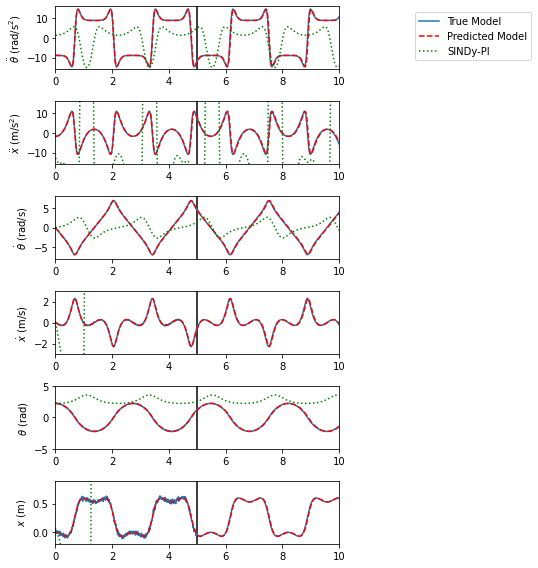

In [15]:
fig, ax = plt.subplots(6,1,figsize=(5,8))

ax[0].plot(t, q_tt_true[0,:], label='True Model')
ax[0].plot(t, q_tt_pred[0,:], 'r--',label='Predicted Model')
ax[0].plot(t, q_tt_spi[0,:], ':g', label='SINDy-PI')
ax[0].set_ylabel('$\ddot{\\theta}$ (rad/s$^2$)')
ax[0].vlines(5,0,1,transform=ax[0].get_xaxis_transform(),colors='k')
ax[0].set_xlim([0,10])
ax[0].set_ylim([-16,16])

ax[1].plot(t, q_tt_true[1,:], label='True Model')
ax[1].plot(t, q_tt_pred[1,:], 'r--',label='Predicted Model')
ax[1].plot(t, q_tt_spi[1,:], ':g',label='SINDy-PI')
ax[1].set_ylabel('$\ddot{x}$ (m/s$^2$)')
ax[1].vlines(5,0,1,transform=ax[1].get_xaxis_transform(),colors='k')
ax[1].set_xlim([0,10])
ax[1].set_ylim([-16,16])

ax[2].plot(t, q_t_true[0,:], label='True Model')
ax[2].plot(t, q_t_pred[0,:], 'r--',label='Predicted Model')
ax[2].plot(t, q_t_spi[0,:], ':g',label='SINDy-PI')
ax[2].set_ylabel('$\dot{\\theta}$ (rad/s)')
ax[2].vlines(5,0,1,transform=ax[2].get_xaxis_transform(),colors='k')
ax[2].set_xlim([0,10])
ax[2].set_ylim([-8,8])

ax[3].plot(t, q_t_true[1,:], label='True Model')
ax[3].plot(t, q_t_pred[1,:], 'r--',label='Predicted Model')
ax[3].plot(t, q_t_spi[1,:], ':g',label='SINDy-PI')
ax[3].set_ylabel('$\dot{x}$ (m/s)')
ax[3].vlines(5,0,1,transform=ax[3].get_xaxis_transform(),colors='k')
ax[3].set_xlim([0,10])
ax[3].set_ylim([-3,3])

ax[4].plot(t, q_true[0,:], label='True Model')
ax[4].plot(t, q_pred[0,:], 'r--',label='Predicted Model')
ax[4].plot(t, q_spi[0,:], ':g',label='SINDy-PI')
ax[4].set_ylabel('$\\theta$ (rad)')
ax[4].vlines(5,0,1,transform=ax[4].get_xaxis_transform(),colors='k')
ax[4].set_xlim([0,10])
ax[4].set_ylim([-5,5])

ax[5].plot(t, q_true[1,:], label='True Model')
ax[5].plot(t, q_pred[1,:], 'r--',label='Predicted Model')
ax[5].plot(t, q_spi[1,:], ':g',label='SINDy-PI')
ax[5].set_ylabel('$x$ (m)')
ax[5].vlines(5,0,1,transform=ax[5].get_xaxis_transform(),colors='k')
ax[5].set_xlim([0,10])
ax[5].set_ylim([-0.2,0.9])

Line, Label = ax[0].get_legend_handles_labels()
fig.legend(Line, Label, loc='upper right', bbox_to_anchor=(1.5, 0.98))

fig.tight_layout()
fig.savefig(rootdir + "Images/training_" + identifier+ "_noise.png", bbox_inches='tight',dpi=400)
